create two datsets X1 and X2 of shape (n, 2)
to solve the task, you need to match the rows of X1 and X2 based on the first column
and y (for X1) is the second col of the matched row

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from embeddings import IndependentLinearEmbedder, GaussianEmbedder, LinearEmbedder


class CrossAttention(nn.Module):
    def __init__(self, emb_dim, value_emb_dim=None, attention_score="dot", std_rbf=1.0, scale=None):
        super(CrossAttention, self).__init__()
        self.emb_dim = emb_dim
        # Linear transformations for query, key, and value
        self.query_proj = nn.Linear(emb_dim, emb_dim)
        self.key_proj = nn.Linear(emb_dim, emb_dim)
        if value_emb_dim is None:
            value_emb_dim = emb_dim
        self.value_proj = nn.Linear(value_emb_dim, value_emb_dim)
        # force the second hald of the query and key proj to be zero
        # self.query_proj.weight.data.T[emb_dim//2:] = 0
        # self.query_proj.bias.data.T[emb_dim//2:] = 0
        # # same for the key
        # self.key_proj.weight.data.T[emb_dim//2:] = 0
        # self.key_proj.bias.data.T[emb_dim//2:] = 0
        # # for the value proj, same for the first half
        # self.value_proj.weight.data.T[:emb_dim//2] = 0
        # self.value_proj.bias.data.T[:emb_dim//2] = 0
        # Scale factor for dot products
        if scale is None:
            self.scale = emb_dim ** -0.5
        else:
            self.scale = scale
        # Attention score function
        self.attention_score = attention_score
        self.std_rbf = std_rbf

    def forward(self, query, key, value):
        # Apply linear projections
        Q = self.query_proj(query)  # Shape: (batch_size, seq_length, emb_dim)
        K = self.key_proj(key)  # Shape: (batch_size, seq_length, emb_dim)
        #K = Q #TODO
        V = self.value_proj(value)  # Shape: (batch_size, seq_length, emb_dim)
        # replace by identity
        #Q = torch.eye(Q.shape[1], device=Q.device).unsqueeze(0).expand(Q.shape[0], -1, -1)
        #K = torch.eye(K.shape[1], device=K.device).unsqueeze(0).expand(K.shape[0], -1, -1)
        #V = torch.eye(V.shape[1], device=V.device).unsqueeze(0).expand(V.shape[0], -1, -1)

        # Calculate the dot product between Q and K^T
        if self.attention_score == "dot":
            attention_scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        elif self.attention_score == "euclidean":
            attention_scores = torch.cdist(Q, K, p=2)**2 * self.scale
            # invert the distance to make it a similarity
            attention_scores = (1.0 - attention_scores) 
        elif self.attention_score == "rbf":
            attention_scores = torch.cdist(Q, K, p=2)**2 * self.scale
            attention_scores = torch.exp(- attention_scores / (2 * self.std_rbf ** 2))
        else:
            raise ValueError(f"Unknown attention_score: {self.attention_score}")

        #return attention_scores
        #attention_scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale  # Shape: (batch_size, seq_length, seq_length)
        # do the euclidean distance instead
    
        #Apply softmax to get the attention weights
        #print("attention_scores", attention_scores)
        attention_weights = F.softmax(attention_scores, dim=-1)  # Shape: (batch_size, seq_length, seq_length)
        if torch.rand(1) < 0.00:
            print("attention_weights", attention_weights.quantile(0.9), attention_weights.quantile(0.1), attention_weights.max(), attention_weights.min())
            print("attention_scores", attention_scores.quantile(0.9), attention_scores.quantile(0.1), attention_scores.max(), attention_scores.min())
        #print("attention_weights", attention_weights)


        #Multiply the attention weights with V
        output = torch.matmul(attention_weights, V)  # Shape: (batch_size, seq_length, emb_dim)

        return output

# Example usage
batch_size, seq_length, emb_dim = 2, 10, 256
query = torch.randn(batch_size, seq_length, emb_dim)
key_value = torch.randn(batch_size, seq_length, emb_dim)  # Using the same tensor for key and value for simplicity

cross_attention = CrossAttention(emb_dim=emb_dim)
output = cross_attention(query, key_value, key_value)  # query attending to key_value
print(output.shape)  # Should be (batch_size, seq_length, emb_dim)


torch.Size([2, 10, 256])


In [23]:
class KNN_module(nn.Module):
    def __init__(self, emb_dim, reverse_output=False, sd=0.1, embedding="gaussian",
        embedding_bias=False, n_features_in=2, n_features_value=1, right_bound=1, attention_score="dot",
        std_rbf=1.0, scale=None):
        super(KNN_module, self).__init__()
        self.emb_dim = emb_dim
        self.reverse_output = reverse_output
        self.n_features_in = n_features_in
        self.n_features_value = n_features_value
        if embedding == "gaussian":
            self.embedder = GaussianEmbedder(emb_dim, sd, left_bound=-0.1, right_bound=right_bound)
        elif embedding == "linear":
            self.embedder = LinearEmbedder(emb_dim, bias=embedding_bias)
        elif embedding == "independent_linear":
            self.embedder = IndependentLinearEmbedder(n_features_in, emb_dim, bias=embedding_bias)
        elif embedding == "no_embedding":
            self.embedder = nn.Identity()
            self.emb_dim = 1
        else:
            raise ValueError("embedding must be 'gaussian' or 'linear'")
        self.cross_attention = CrossAttention(emb_dim=n_features_in * self.emb_dim, value_emb_dim=n_features_value * self.emb_dim, attention_score=attention_score,
            std_rbf=std_rbf, scale=scale)
        if self.reverse_output:
            self.linear = nn.Linear(n_features_value*self.emb_dim, self.emb_dim)
        else:
            self.linear = nn.Linear(n_features_value*self.emb_dim, 1)
    
    def forward(self, X1, X2, X3=None):
        emb_X1 = self.embedder(X1).reshape(1, X1.shape[0], self.emb_dim * self.n_features_in)
        emb_X2 = self.embedder(X2).reshape(1, X2.shape[0], self.emb_dim * self.n_features_in)
        # add random noise to the embeddings
        #emb_X1 += torch.randn_like(emb_X1) * 1
        #emb_X2 += torch.randn_like(emb_X2) * 1
        if X3 is not None:
            emb_X3 = self.embedder(X3).reshape(1, X3.shape[0], self.emb_dim * self.n_features_value)
            cross_attention_output = self.cross_attention(emb_X1, emb_X2, emb_X3)
        else:
            cross_attention_output = self.cross_attention(emb_X1, emb_X2, emb_X2)
        output = self.linear(cross_attention_output)
        if self.reverse_output:
            output = self.embedder.revert(output)
        return output

In [25]:
def generate_data(n):
    # Step 1: Generate a unique sequence for matching
    match_seq = np.arange(n)
    #np.random.seed(42)  # For reproducibility
    permutation = np.random.permutation(match_seq)

    # Step 2: Shuffle the sequences differently for X1 and X2

    # Step 3: Generate random values for the second column
    y = np.random.rand(n)  # Random values for X1
    X1_second_col = np.random.rand(n)  # Random values for X2, to be used as targets for X1
    X1_first_col = np.random.rand(n)  # Random values for X2, to be used as targets for X1

    # Construct X1 and X2
    X1 = np.column_stack((X1_first_col, X1_second_col))
    X2 = np.column_stack((2 * X1_first_col[permutation], y[permutation]))

    X1 = torch.tensor(X1).unsqueeze(-1).float()
    X2 = torch.tensor(X2).unsqueeze(-1).float()
    y = torch.tensor(y).float().unsqueeze(0)

    return X1, X2, y
    

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming `KNN_module` is defined elsewhere and `emb_dim` is specified
# For illustration, replace `KNN_module(emb_dim)` with your actual model

def train(embedding="gaussian", embedding_bias=False, attention_score="dot"):
    model = KNN_module(256, reverse_output=False, sd=[2/256], embedding_bias=embedding_bias, embedding=embedding, right_bound=2.1,
    n_features_in=2, n_features_value=2, attention_score=attention_score, std_rbf=(2/256) / np.sqrt(2), scale=1.)

    # # write the correct matrix by hand
    # model.cross_attention.query_proj.weight.data = torch.zeros_like(model.cross_attention.query_proj.weight.data)
    # # add identity in the upper left
    # model.cross_attention.query_proj.weight.data[:256, :256] = torch.eye(256)
    # # take the transpose
    # model.cross_attention.query_proj.weight.data = model.cross_attention.query_proj.weight.data.T
    # # same for key
    # model.cross_attention.key_proj.weight.data = torch.zeros_like(model.cross_attention.key_proj.weight.data)
    # model.cross_attention.key_proj.weight.data[:256, :256] = torch.eye(256)
    # model.cross_attention.key_proj.weight.data = model.cross_attention.key_proj.weight.data.T
    # # same for value, but in the lower right
    # model.cross_attention.value_proj.weight.data = torch.zeros_like(model.cross_attention.value_proj.weight.data)
    # model.cross_attention.value_proj.weight.data[256:, 256:] = torch.eye(256)
    # model.cross_attention.value_proj.weight.data = model.cross_attention.value_proj.weight.data.T
    # # for model.read_out, just take the mean (i.e weights are 1/256)
    # model.linear.weight.data = torch.ones_like(model.linear.weight.data) / 256
    # # no training for these 
    # model.cross_attention.query_proj.weight.requires_grad = False
    # model.cross_attention.key_proj.weight.requires_grad = False
    # model.cross_attention.value_proj.weight.requires_grad = False
    # model.linear.weight.requires_grad = False
    # # remove all the biases
    # model.cross_attention.query_proj.bias.data.fill_(0)
    # model.cross_attention.key_proj.bias.data.fill_(0)
    # model.cross_attention.value_proj.bias.data.fill_(0)
    # model.linear.bias.data.fill_(0)
    # # and grad for the biases
    # model.cross_attention.query_proj.bias.requires_grad = False
    # model.cross_attention.key_proj.bias.requires_grad = False
    # model.cross_attention.value_proj.bias.requires_grad = False
    # model.linear.bias.requires_grad = False


    # Define a loss function, e.g., MSE for regression tasks
    criterion = nn.MSELoss()

    # Define an optimizer, e.g., Adam
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Assuming `X1`, `X2`, and `targets` are your datasets
    # `targets` would be the correct matches from `X2` for rows in `X1`
    # For simplicity, let's say it's the second column from X2 matched to X1
    # You would need to prepare this based on your specific task

    # Convert targets to a PyTorch tensor and ensure the shape and type match your model's output
    #targets = y # Assuming this is how you extract targets

    # Training loop
    num_epochs = 10_000  # Number of epochs to train for
    #num_epochs = 3

    rmse_list = []
    for epoch in range(num_epochs):
        # Zero the parameter gradients
        optimizer.zero_grad()

        X1, X2, targets = generate_data(256)

        # Forward pass
        outputs = model(X1, X2).squeeze(-1)
        
        # Compute loss
        loss = criterion(outputs, targets)  # Make sure targets shape matches output

        # Backward pass and optimize
        loss.backward()
        optimizer.step()


        # Print statistics
        if epoch % 100 == 0:  # Print every 10 epochs
            # compute loss for a constant prediction)
            loss_const = criterion(torch.mean(targets, dim=1).repeat(targets.shape), targets)
            print(f'Epoch {epoch+1}, Loss: {loss.item()}', f'Loss constant prediction: {loss_const.item()}')
            #print("scale", model.embedder.scale)
        
        if epoch % 1000 == 0:
            with torch.no_grad():
                model.eval()
                rmse_list_temp = []
                for _ in range(10):
                    X1, X2, targets = generate_data(256)
                    outputs = model(X1, X2).squeeze(-1)
                    rmse = torch.sqrt(criterion(outputs, targets))
                    #print("RMSE", rmse)
                    rmse_list_temp.append(rmse)
                rmse_list.append(torch.mean(torch.tensor(rmse_list_temp)).item())
    
    return rmse_list




In [42]:
import pandas as pd
results = []

for iter in range(5):
    for embedding in ["gaussian"]:
        for attention_score in ["dot", "euclidean", "rbf"]:
            rmse_list = train(embedding=embedding, attention_score=attention_score)
            results.append(
                {
                    "embedding": embedding,
                    "attention_score": attention_score,
                    "rmse_list": rmse_list,
                    "iter": iter,
                }
            )
            df = pd.DataFrame(results)
            df.to_csv("results_differentiable_knn.csv")

    for embedding in ["linear"]:
        for embedding_bias in [False, True]:
            for attention_score in ["dot", "euclidean", "rbf"]:
                rmse_list = train(embedding=embedding, embedding_bias=embedding_bias, attention_score=attention_score)
                results.append(
                    {
                        "embedding": embedding,
                        "embedding_bias": embedding_bias,
                        "attention_score": attention_score,
                        "rmse_list": rmse_list,
                        "iter": iter
                    }
                )
                df = pd.DataFrame(results)
                df.to_csv("results_differentiable_knn.csv")




Epoch 1, Loss: 0.36886167526245117 Loss constant prediction: 0.08877328783273697
Epoch 101, Loss: 0.08435554802417755 Loss constant prediction: 0.08431783318519592
Epoch 201, Loss: 0.08130338042974472 Loss constant prediction: 0.08119478821754456
Epoch 301, Loss: 0.08149373531341553 Loss constant prediction: 0.08087336272001266
Epoch 401, Loss: 0.08058595657348633 Loss constant prediction: 0.08050180971622467
Epoch 501, Loss: 0.07781514525413513 Loss constant prediction: 0.07781489193439484
Epoch 601, Loss: 0.08183827996253967 Loss constant prediction: 0.08153915405273438
Epoch 701, Loss: 0.07488308846950531 Loss constant prediction: 0.07487645745277405
Epoch 801, Loss: 0.0876287966966629 Loss constant prediction: 0.08744065463542938
Epoch 901, Loss: 0.0804540291428566 Loss constant prediction: 0.08001695573329926
Epoch 1001, Loss: 0.08644875138998032 Loss constant prediction: 0.08600126206874847
Epoch 1101, Loss: 0.08219752460718155 Loss constant prediction: 0.08220385015010834
Epoch 

In [15]:
import pandas as pd
df = pd.read_csv("results_differentiable_knn.csv")

In [16]:
import ast
# replace "nan" with None
#df['rmse_list'] = df['rmse_list'].str.replace('nan', 'None')
#df['loss_list'] = df['loss_list'].str.replace('nan', 'None')
#df['test_loss_list'] = df['test_loss_list'].apply(lambda s: pd.eval(s))
#df['loss_list'] = df['loss_list'].apply(lambda s: pd.eval(s))

df['rmse_list'] = df['rmse_list'].apply(ast.literal_eval)
#df['rmse_list'] = df['rmse_list'].apply(ast.literal_eval)

# Create a new DataFrame for Plotly Express
rows_list = []
for _, row in df.iterrows():
    params = row.to_dict()
    rmse_list = params.pop('rmse_list')
    for epoch, rmse in enumerate(rmse_list):
        params['epoch'] = epoch
        params['rmse'] = rmse
        rows_list.append(params.copy())  # Use .copy() to avoid modifying the original params

# Create a new DataFrame
df_long = pd.DataFrame(rows_list)
df_long = df_long.fillna("missing")

# remove Unnamed columns
df_long = df_long.loc[:, ~df_long.columns.str.contains('^Unnamed')]

In [9]:
model.embedder.scale

Parameter containing:
tensor(1.0363, requires_grad=True)

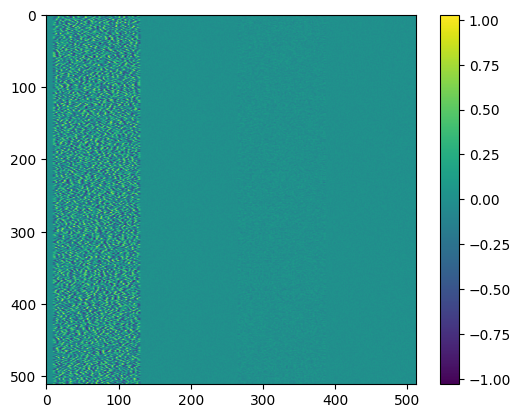

In [10]:
import matplotlib.pyplot as plt
plt.imshow(model.cross_attention.query_proj.weight.detach())
plt.colorbar()

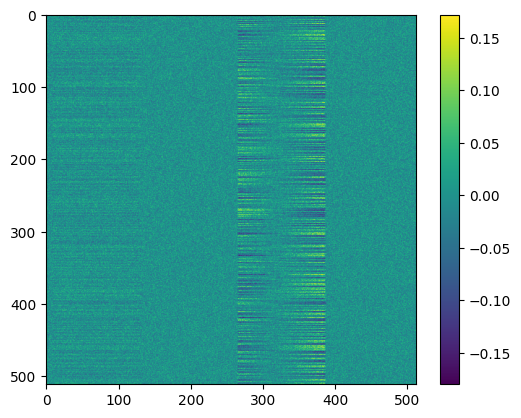

In [13]:
import matplotlib.pyplot as plt
plt.imshow(model.cross_attention.value_proj.weight.detach())
plt.colorbar()

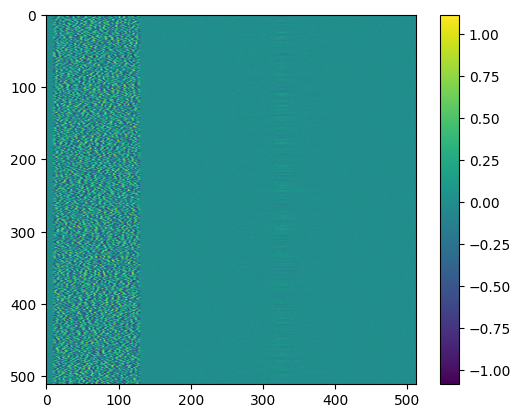

In [14]:
import matplotlib.pyplot as plt
plt.imshow(model.cross_attention.key_proj.weight.detach())
plt.colorbar()